## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# import sklearn.external.joblib as extjoblib
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow  import  random

import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)
from scipy.fft import fft

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

2024-03-08 16:01:29.033378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 16:01:29.181577: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 16:01:29.188663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-08 16:01:29.188687: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
# set random seed
seed(10)
random.set_seed(10)

# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [93]:
# # load, average and merge sensor samples
# data_dir = 'Data/Bearing_Sensor_Data_pt1'
# from scipy.fft import fft
# merged_data = pd.DataFrame()
# newdata = pd.DataFrame()
# i = 0
# for filename in os.listdir(data_dir):
#     # if i < 1 :
#     dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')

#     signal = dataset
#     fft_result = fft(dataset)
#     magnitude_spectrum = np.abs(fft_result)
#     sample_rate = 20480  # This is an example value; you should use your actual sampling rate
#     frequencies = np.fft.fftfreq(dataset.size, d=1/sample_rate).mean()
#     mean_of_fft = np.mean(magnitude_spectrum)
#     dataset_mean_abs = np.array(dataset.abs().mean())
#     dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
#     dataset_mean_abs.index = [filename]
#     fft_result0 = fft(np.array(signal.iloc[:, 0]).reshape(1,-1))
#     fft_result1 =fft(np.array(signal.iloc[:, 1]).reshape(1,-1))
#     fft_result2 =fft(np.array(signal.iloc[:, 2]).reshape(1,-1))
#     fft_result3 =fft(np.array(signal.iloc[:, 3]).reshape(1,-1))
#     magnitude_spectrum0 = np.abs(fft_result0)
#     magnitude_spectrum1= np.abs(fft_result1)
#     magnitude_spectrum2 = np.abs(fft_result2)
#     magnitude_spectrum3 = np.abs(fft_result3)
#     mean_of_fft0 = np.mean(magnitude_spectrum0)
#     mean_of_fft1 = np.mean(magnitude_spectrum1)
#     mean_of_fft2 = np.mean(magnitude_spectrum2)
#     mean_of_fft3 = np.mean(magnitude_spectrum3)

#     sample_rate = 20478  # This is an example value; you should use your actual sampling rate
#     frequencies1= np.fft.fftfreq(signal.iloc[:, 0].size, d=1/sample_rate).mean()
#     frequencies2 = np.fft.fftfreq(signal.iloc[:, 1].size, d=1/sample_rate).mean()
#     frequencies3 = np.fft.fftfreq(signal.iloc[:, 2].size, d=1/sample_rate).mean()
#     frequencies4 = np.fft.fftfreq(signal.iloc[:, 3].size, d=1/sample_rate).mean()
#     frq = np.array([frequencies1,frequencies2,frequencies3,frequencies4]).reshape(1,4)
#     fft_mean = np.array([mean_of_fft0,mean_of_fft1,mean_of_fft2,mean_of_fft3 ]).reshape(1,4)
#     dataset_mean_fft = pd.DataFrame(fft_mean)
#     dataset_mean_abs.columns = ['mean_Bearing_1', 'mean_Bearing_2', 'mean_Bearing_3', 'mean_Bearing_4']

#     dataset_mean_fft.index = [filename]
#     dataset_mean_fft.columns = ['mean_fft_Bearing_1', 'mean_fft_Bearing_2', 'mean_fft_Bearing_3', 'mean_fft_Bearing_4']
#     dataset_mean_frq = pd.DataFrame(frq)
#     dataset_mean_frq.index = [filename]
#     dataset_mean_frq.columns = ['mean_frq_Bearing_1', 'mean_frq_Bearing_2', 'mean_frq_Bearing_3', 'mean_frq_Bearing_4']


#     merged_data = merged_data.append(pd.concat([dataset_mean_abs , dataset_mean_fft,dataset_mean_frq ],axis=1 ))



# merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

/tmp/ipykernel_141048/3850785889.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(pd.concat([dataset_mean_abs , dataset_mean_fft,dataset_mean_frq ],axis=1 ))
/tmp/ipykernel_141048/3850785889.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(pd.concat([dataset_mean_abs , dataset_mean_fft,dataset_mean_frq ],axis=1 ))
/tmp/ipykernel_141048/3850785889.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(pd.concat([dataset_mean_abs , dataset_mean_fft,dataset_mean_frq ],axis=1 ))
/tmp/ipykernel_141048/3850785889.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

/tmp/ipykernel_141048/3850785889.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(pd.concat([dataset_mean_abs , dataset_mean_fft,dataset_mean_frq ],axis=1 ))
/tmp/ipykernel_141048/3850785889.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(pd.concat([dataset_mean_abs , dataset_mean_fft,dataset_mean_frq ],axis=1 ))
/tmp/ipykernel_141048/3850785889.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(pd.concat([dataset_mean_abs , dataset_mean_fft,dataset_mean_frq ],axis=1 ))
/tmp/ipykernel_141048/3850785889.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [3]:
# merged_data.to_csv ("data_signal.csv")

NameError: name 'merged_data' is not defined

In [12]:
merged_data = pd.read_csv("data_signal.csv" ,index_col=0 )
# dataset2 = pd.read_csv("Data/Bearing_Sensor_Data_pt2/2004.02.18.19.52.39", sep='\t')


In [13]:
merged_data

,Sensor_1_Signal_Strength,Sensor_2_Signal_Strength,Sensor_3_Signal_Strength,Sensor_4_Signal_Strength
Index,,,,
0,-0.003352,-0.002483,-0.001328,-0.000229
1,-0.003129,-0.002465,-0.001385,-0.000302
2,-0.002895,-0.002439,-0.001437,-0.000373
3,-0.002650,-0.002404,-0.001484,-0.000442
4,-0.002397,-0.002360,-0.001526,-0.000511
...,...,...,...,...
9995,-0.001704,-0.002317,-0.001715,-0.000762
9996,-0.001370,-0.002232,-0.001733,-0.000823
9997,-0.001032,-0.002139,-0.001745,-0.000881


In [ ]:
# from scipy.fft import fft
# mean_value =np.mean(signal)
# fft_result0 = fft(np.array(signal.iloc[:, 0]).reshape(1,-1))
# fft_result1 =fft(np.array(signal.iloc[:, 1]).reshape(1,-1))
# fft_result2 =fft(np.array(signal.iloc[:, 2]).reshape(1,-1))
# fft_result3 =fft(np.array(signal.iloc[:, 3]).reshape(1,-1))
# magnitude_spectrum0 = np.abs(fft_result0)
# magnitude_spectrum1= np.abs(fft_result1)
# magnitude_spectrum2 = np.abs(fft_result2)
# magnitude_spectrum3 = np.abs(fft_result3)
# mean_of_fft0 = np.mean(magnitude_spectrum0)
# mean_of_fft1 = np.mean(magnitude_spectrum1)
# mean_of_fft2 = np.mean(magnitude_spectrum2)
# mean_of_fft3 = np.mean(magnitude_spectrum3)

# sample_rate = 20478  # This is an example value; you should use your actual sampling rate
# frequencies1= np.fft.fftfreq(signal.iloc[:, 0].size, d=1/sample_rate).mean()
# frequencies2 = np.fft.fftfreq(signal.iloc[:, 1].size, d=1/sample_rate).mean()
# frequencies3 = np.fft.fftfreq(signal.iloc[:, 2].size, d=1/sample_rate).mean()
# frequencies4 = np.fft.fftfreq(signal.iloc[:, 3].size, d=1/sample_rate).mean()
# frq = np.array([frequencies1,frequencies2,frequencies3,frequencies4]).reshape(1,4)
# fft_mean = np.array([mean_of_fft0,mean_of_fft1,mean_of_fft2,mean_of_fft3 ]).reshape(1,4)
# dataset_mean_fft = pd.DataFrame(fft_mean)
# f ={"mean_value":mean_value ,   "frequencies":frq , "mean_of_fft":fft_mean  }

/home/medi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
# dataset_mean_fft

,0,1,2,3
0,8.685012,9.677204,11.381775,5.587612


In [4]:
merged_data = pd.read_csv("new_preprocces.csv" ,index_col=0)

In [7]:
merged_data

,mean_Bearing_1,mean_Bearing_2,mean_Bearing_3,mean_Bearing_4,mean_fft_Bearing_1,mean_fft_Bearing_2,mean_fft_Bearing_3,mean_fft_Bearing_4,mean_frq_Bearing_1,mean_frq_Bearing_2,mean_frq_Bearing_3,mean_frq_Bearing_4
2004.02.16.16.22.39,0.073814,0.074713,0.075640,0.044425,8.685012,9.677204,11.381775,5.587612,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14
2004.02.15.16.42.39,0.059662,0.073159,0.075952,0.042869,7.607822,9.477400,11.430724,5.467980,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14
2004.02.17.16.52.39,0.092946,0.078138,0.077772,0.050036,10.751428,9.969002,11.251391,6.076695,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14
2004.02.15.12.22.39,0.060525,0.074383,0.078142,0.044174,7.732320,9.737709,11.719136,5.653051,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14
2004.02.17.02.42.39,0.078344,0.074184,0.079004,0.046181,8.856907,9.536965,11.403566,5.843177,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14
...,...,...,...,...,...,...,...,...,...,...,...,...
2004.02.17.05.22.39,0.080938,0.074446,0.076789,0.046424,9.202270,9.772762,11.390356,5.842343,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14
2004.02.18.18.52.39,0.130306,0.095007,0.098383,0.057174,12.252105,10.159212,11.438099,6.277068,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14
2004.02.16.22.32.39,0.081473,0.073664,0.076272,0.045967,9.204985,9.623845,11.312013,5.803845,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14
2004.02.18.23.52.39,0.145859,0.108005,0.120645,0.068641,13.501436,10.471521,11.709415,6.515094,9.095391e-14,9.095391e-14,9.095391e-14,9.095391e-14


In [14]:
# transform data file index to datetime and sort in chronological order
# merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
# merged_data = merged_data.sort_index()
# merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
# print("Dataset shape:", merged_data.shape)
# merged_data.head()

/home/medi/.pyenv/versions/3.10.6/envs/taxifare-env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/medi/.pyenv/versions/3.10.6/envs/taxifare-env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


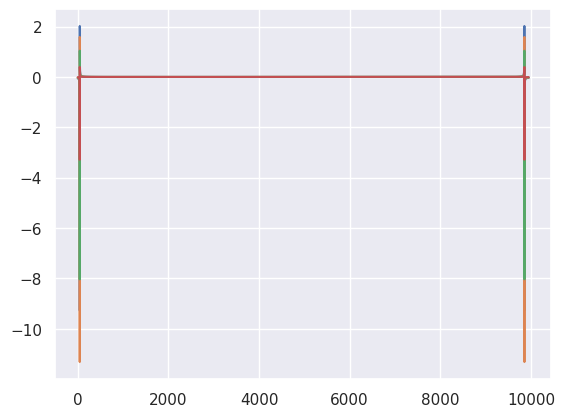

In [15]:
g = fft(np.array(merged_data.iloc[:, 0]).reshape(1,-1))
g[0]
plt.plot(g[0][50:])
h = fft(np.array(merged_data.iloc[:, 1]).reshape(1,-1))

plt.plot(h[0][50:])
y = fft(np.array(merged_data.iloc[:, 2]).reshape(1,-1))

plt.plot(y[0][50:])
j = fft(np.array(merged_data.iloc[:, 3]).reshape(1,-1))

plt.plot(j[0][50:])
# plt.plot(merged_data['mean_frq_Bearing_1'])
# plt.plot(merged_data['Bearing 4'])

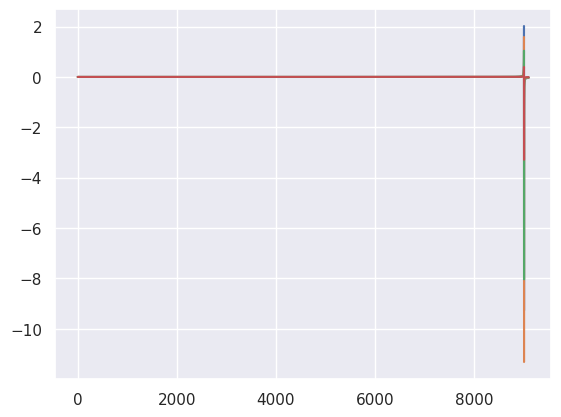

In [16]:
range=900
g = fft(np.array(merged_data.iloc[:, 0]).reshape(1,-1))
g[0]
plt.plot(g[0][range:])
h = fft(np.array(merged_data.iloc[:, 1]).reshape(1,-1))

plt.plot(h[0][range:])
y = fft(np.array(merged_data.iloc[:, 2]).reshape(1,-1))

plt.plot(y[0][range:])
j = fft(np.array(merged_data.iloc[:, 3]).reshape(1,-1))

plt.plot(j[0][range:])

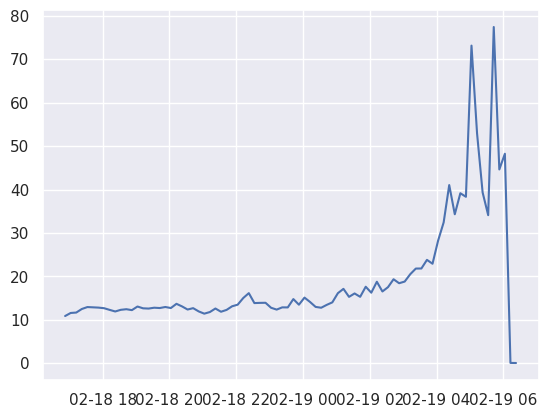

In [ ]:

# plt.plot(merged_data['mean_fft_Bearing_2'])
# plt.plot(merged_data['mean_fft_Bearing_3'])
# plt.plot(merged_data['mean_fft_Bearing_4'])

# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [17]:
train = merged_data[: 8000]
test = merged_data[8000:]
# test_norm = merged_data[600:750]
# test_start = merged_data[730:880]


print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (8000, 4)
Test dataset shape: (2000, 4)


KeyError: 'mean_Bearing_1'

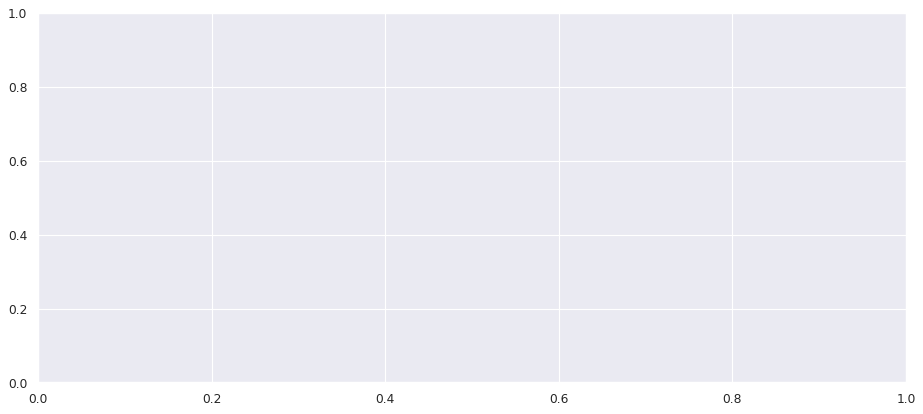

In [18]:
# fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
# ax.plot(train['mean_Bearing_1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
# ax.plot(train['mean_Bearing_2'], label='Bearing 2', color='red', animated = True, linewidth=1)
# ax.plot(train['mean_Bearing_3'], label='Bearing 3', color='green', animated = True, linewidth=1)
# ax.plot(train['mean_Bearing_4'], label='Bearing 4', color='black', animated = True, linewidth=1)
# plt.legend(loc='lower left')
# ax.set_title('Bearing Sensor Training Data', fontsize=16)
# plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [12]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)
test_nor_fft = np.fft.fft(test_norm)

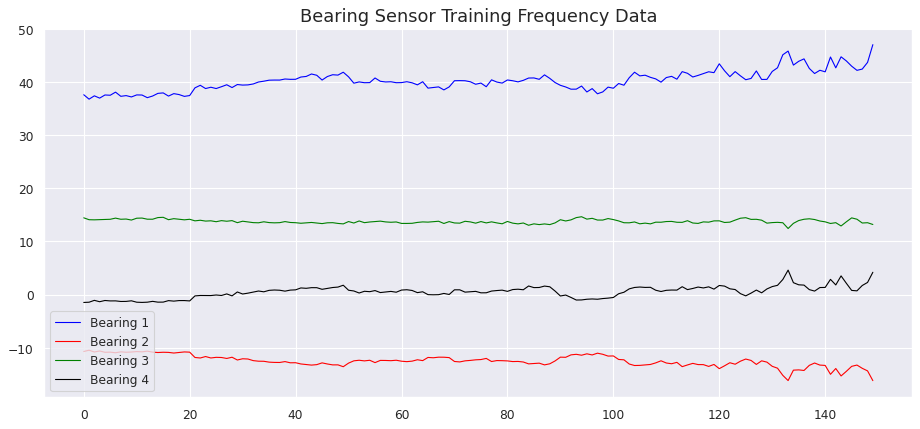

In [13]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

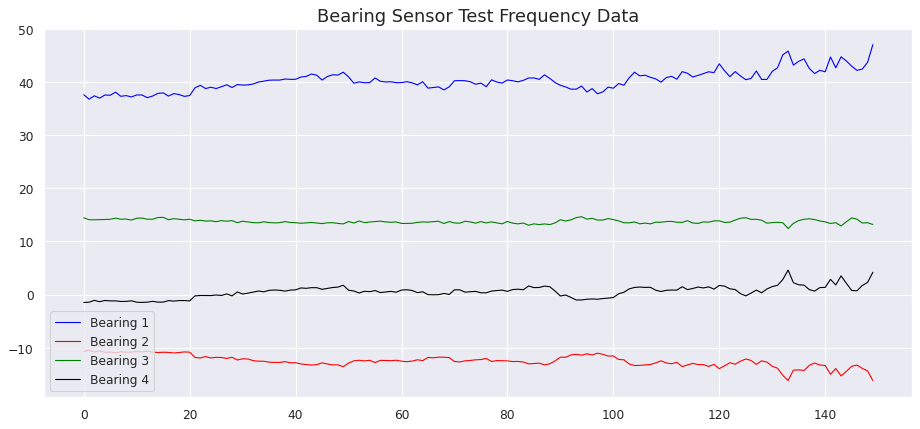

In [14]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [32]:
fail_data = pd.read_csv("test_data11.csv" , index_col=0 )

In [39]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
X_test_fial = scaler.transform(fail_data[:2000])
# X_test_start = scaler.transform(test_start)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [40]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_test_fial = X_test_fial.reshape(X_test_fial.shape[0], 1, X_test_fial.shape[1])
# X_test_start = X_test_start.reshape(X_test_start.shape[0], 1, X_test_start.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (8000, 1, 4)
Test data shape: (2000, 1, 4)


In [21]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [22]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

2024-03-08 16:10:42.445894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-08 16:10:42.446632: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-08 16:10:42.446776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mediwin): /proc/driver/nvidia/version does not exist
2024-03-08 16:10:42.448560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [24]:
# fit the model to the data
nb_epochs = 30
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/30
760/760 [==============================] - 6s 8ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 2/30
760/760 [==============================] - 6s 8ms/step - loss: 0.0026 - val_loss: 0.0053
Epoch 3/30
760/760 [==============================] - 4s 6ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 4/30
760/760 [==============================] - 5s 6ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 5/30
760/760 [==============================] - 5s 6ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 6/30
760/760 [==============================] - 6s 7ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 7/30
760/760 [==============================] - 5s 7ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 8/30
760/760 [==============================] - 6s 8ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 9/30
760/760 [==============================] - 4s 6ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 10/30
760/760 [==============================] - 4s 5ms/step - loss: 0.0026 - val_loss: 0.0044

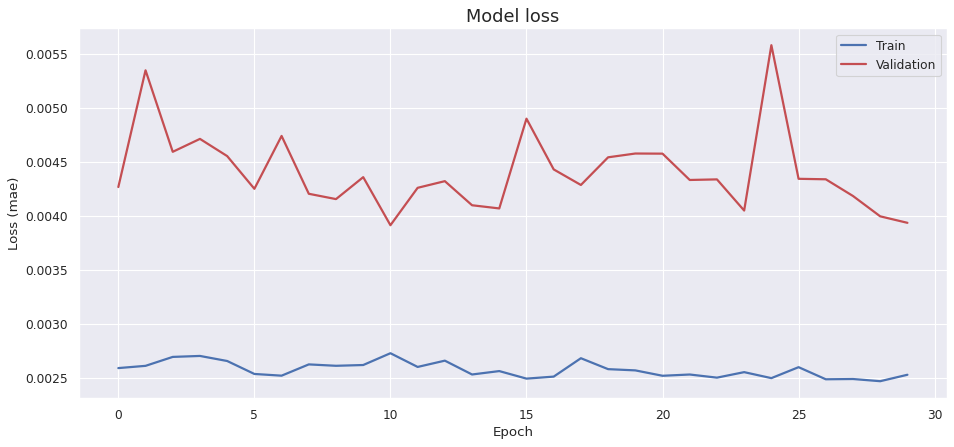

In [25]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

250/250 [==============================] - 1s 3ms/step


/tmp/ipykernel_183951/3269023118.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

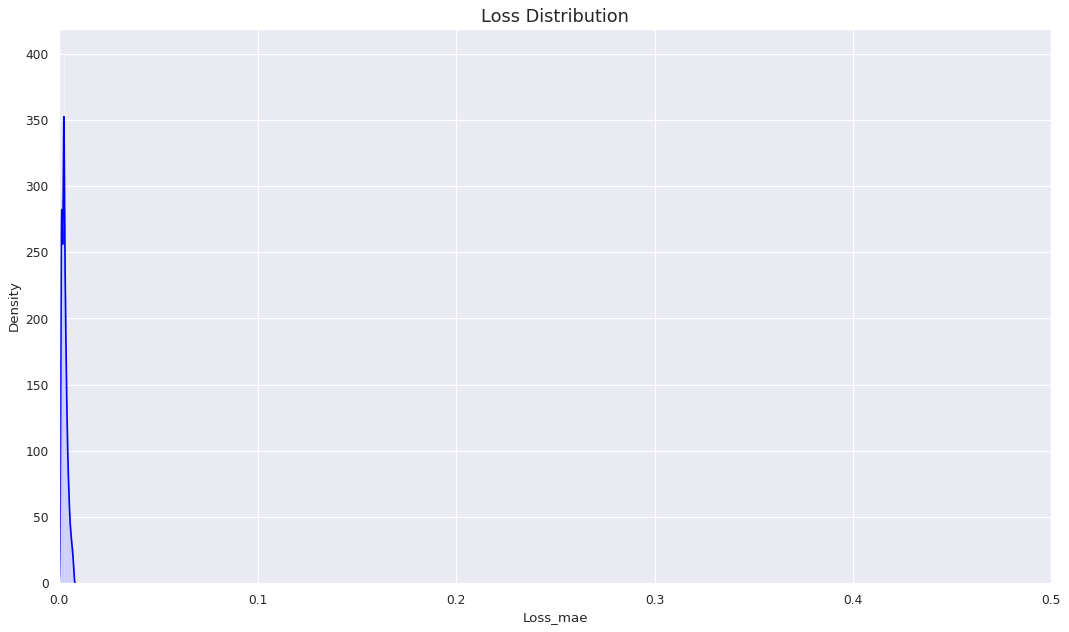

In [26]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [27]:
gg = X_test.reshape(X_test.shape[0], X_test.shape[2])
list (gg[:,1])


[0.6808042440578549,
 0.7080592053381417,
 0.7345875338245074,
 0.760296473354497,
 0.7850961309219888,
 0.8088997909932307,
 0.8316242187196641,
 0.8531899509880241,
 0.87352157428694,
 0.8925479884229393,
 0.9102026551589424,
 0.9264238309075397,
 0.9411547826675607,
 0.9543439864452155,
 0.965945307468661,
 0.9759181615625574,
 0.9842276571215203,
 0.9908447171842616,
 0.995746181180279,
 0.9989148859952046,
 1.0003397260691185,
 1.0000156923189456,
 0.9979438897473897,
 0.9941315336773365,
 0.9885919246236681,
 0.981344401890633,
 0.9724142760572134,
 0.9618327405840823,
 0.9496367628541449,
 0.9358689550233081,
 0.9205774251357308,
 0.9038156090240786,
 0.885642083578108,
 0.866120362039027,
 0.8453186720317492,
 0.8233097171115649,
 0.800170422661633,
 0.7759816670216588,
 0.750827998798259,
 0.7247973413340179,
 0.697980685377279,
 0.6704717710225425,
 0.6423667600318006,
 0.6137638996874578,
 0.5847631793469366,
 0.5554659808998526,
 0.5259747243570261,
 0.4963925097964039,
 0.

In [30]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.09
scored['good'] = scored['Loss_mae'] < scored['Threshold']
scored.head()

63/63 [==============================] - 0s 4ms/step


,Loss_mae,Threshold,good
Index,,,
8000,0.007574,0.09,True
8001,0.007568,0.09,True
8002,0.007295,0.09,True
8003,0.007164,0.09,True
8004,0.007475,0.09,True


In [41]:
X_pred = model.predict(X_test_fial)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test_fial.reshape(X_test_fial.shape[0], X_test_fial.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.05
scored['waring'] = scored['Loss_mae'] < scored['Threshold']
scored.head()

63/63 [==============================] - 0s 5ms/step


,Loss_mae,Threshold,waring
Index,,,
8000,0.122274,0.05,False
8001,0.195964,0.05,False
8002,0.246122,0.05,False
8003,0.282612,0.05,False
8004,0.285202,0.05,False


In [23]:
X_pred = model.predict(X_test_start)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test_start.reshape(X_test_start.shape[0], X_test_start.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.05
scored['waring'] = scored['Loss_mae'] < scored['Threshold']
scored.head()

5/5 [==============================] - 0s 5ms/step


,Loss_mae,Threshold,waring
2004-02-18 00:12:39,0.039468,0.05,True
2004-02-18 00:22:39,0.032398,0.05,True
2004-02-18 00:32:39,0.029530,0.05,True
2004-02-18 00:42:39,0.026919,0.05,True
2004-02-18 00:52:39,0.035504,0.05,True


In [24]:
# calculate the same metrics for the training set
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

5/5 [==============================] - 0s 4ms/step


Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:>

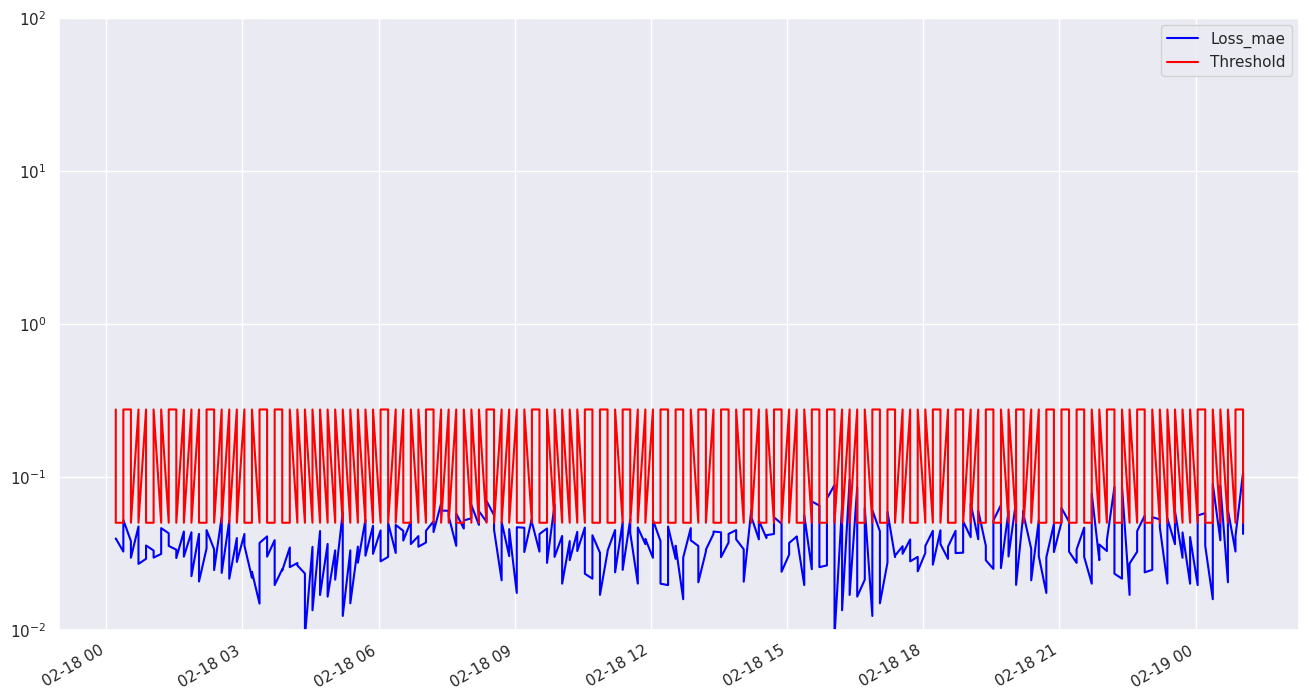

In [25]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [26]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved


In [27]:
from tensorflow.keras.models import load_model
model = load_model('Cloud_model.h5')